# Final Project @ Ironhack by Jesús Badenes

## Description

The goal of this project is to classify news as either likely true or likely fake based on a dataset of over 60,000 news articles, approximately half of which are true and half of which are fake. The articles used in the training data have been labeled as true / fake by the organization PolitiFact and come from different news sources, such as The Huffington Post, CNN, CNBC, Facebook and the BBC and are all in English. 

We have approached this problem as a binary classification problem, trying to make a prediction of true or fake based on the title and the text of the articles. We have used different Machine Learning modeling techniques, including Linear Regression, Decision Trees, Random Forests, Support Vector Machines and two different Neural Networks. 

## Code

### Library Import

In [247]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import contractions
import re
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import dump

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jesusb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jesusb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jesusb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Upload

#### First source

Source: https://www.kaggle.com/code/therealsampat/fake-news-detection/input (data originally retrieved from the Huffington Post)

In [142]:
#Reading our data

df_true = pd.read_csv("Fake.csv", delimiter=',', on_bad_lines='skip')
df_fake = pd.read_csv("True.csv", delimiter=',', on_bad_lines='skip')

In [143]:
df_true.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [144]:
df_fake.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [145]:
df_true.shape

(23481, 4)

In [146]:
df_fake.shape

(21417, 4)

#### Second source

Source: https://ieee-dataport.org/open-access/fnid-fake-news-inference-dataset

We read additional data and convert it into Pandas dataframes

In [147]:
df_dev = pd.read_csv("fnn_dev.csv", delimiter=',', on_bad_lines='skip')

In [148]:
df_test = pd.read_csv("fnn_test.csv", delimiter=',', on_bad_lines='skip')

In [149]:
df_train = pd.read_csv("fnn_train.csv", delimiter=',', on_bad_lines='skip')

In [150]:
#We concat the three datasets into one

df1 = pd.concat([df_dev, df_test, df_train], axis = 0)
df1.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake
3,1557,2010-03-05T18:24:02-05:00,Dave Aronberg,"Says Gov. Charlie Crist has called him ""a rock...","['http://www.davearonberg.com/about', 'http://...","[""State Sen. Dave Aronberg, a Democratic candi...","State Sen. Dave Aronberg, a Democratic candida...",real
4,12826,2016-07-29T18:09:31-04:00,Jeannette Vaught,"""Only five Texas counties account for almost 9...",['http://www.mystatesman.com/news/news/opinion...,['From the citrus of the Rio Grande Valley to ...,From the citrus of the Rio Grande Valley to th...,fake


In [151]:
#We select the relevant features only

df1 = df1[["statement", "fullText_based_content", "date", "label_fnn"]]

In [152]:
#We replace the target variables for 0 and 1

df1["label_fnn"] = df1["label_fnn"].apply(lambda x: 0 if x == "real" else 1)

In [153]:
#We check the distribution of our target variable

df1["label_fnn"].value_counts()

0    8767
1    8557
Name: label_fnn, dtype: int64

In [154]:
#We rename the columns to make them coherent with our previous data

df1 = df1.rename(columns={"statement": "title", "fullText_based_content": "text", "label_fnn": "target"})

In [155]:
#We do a final visual check on our data

df1.head()

,title,text,date,target
0,"Rubio's tax swap proposal ""would have been a m...",Gov. Charlie Crist launched what amounts to a ...,2010-03-28T17:45:34-04:00,1
1,"""The estimated savings of this (debt ceiling) ...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",2011-08-29T06:00:00-04:00,0
2,"Foxconn has already ""made a positive impact ac...",Amid reports questioning Foxconn Technology Gr...,2019-02-12T17:35:38-05:00,1
3,"Says Gov. Charlie Crist has called him ""a rock...","State Sen. Dave Aronberg, a Democratic candida...",2010-03-05T18:24:02-05:00,0
4,"""Only five Texas counties account for almost 9...",From the citrus of the Rio Grande Valley to th...,2016-07-29T18:09:31-04:00,1


### Basic Data Cleaning

In [178]:
#We define a function to make the date format homogeneous across df1 and df

def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S%z")
    formatted_date = date_obj.strftime("%B %d, %Y")
    return formatted_date

#We apply the function to the entire DataFrame

df1["date"] = df1["date"].apply(convert_date_format)

In [179]:
#Inserting Target variable into part of our data

df_true["target"] = 0
df_fake["target"] = 1

In [180]:
#Removing the reference to the location & the source in the fake dataset, as that is irrelevant information

df_fake['text'] = df_fake['text'].apply(lambda x: x.split(') - ', 1)[-1])
df_fake.head(10)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",1
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017",1
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017",1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017",1


In [181]:
#Concating the two datasets for our first data source (which was split into true and fake)

df = pd.concat([df_true, df_fake], axis = 0)
df.shape

(44898, 5)

In [182]:
#Random shuffling the rows to get a view on True and Fake news

df = df.sample(frac = 1)
df.reset_index(inplace = True)
df.head(10)

,index,title,text,subject,date,target
0,17019,MOTHER OF BENGHAZI VICTIM Rips Into Clueless C...,CNN Anchor Carol Costello acts like she s neve...,Government News,"Oct 21, 2015",0
1,18243,PICTURE OF Cop Walking Son To School On Day He...,"So what s worse, Barack Obama remaining silent...",left-news,"Jul 29, 2017",0
2,8192,The Amazing White Right-Wing Entitlement Of T...,"As of this writing, there are 4 heavily armed ...",News,"February 11, 2016",0
3,18034,WATCH: JOEL OSTEEN FACES WRATH OF ANGRY CHRIST...,The popular evangelical preacher and inspirati...,left-news,"Aug 31, 2017",0
4,7763,North Carolina offers reward in arson at local...,"North Carolina will pay up to $5,000 for tips ...",politicsNews,"October 19, 2016",1
5,5815,U.S. House Republicans finalize list of rules ...,Republicans pressed ahead in their deregulator...,politicsNews,"January 31, 2017",1
6,6907,New House labor committee chair questions need...,The incoming chair of the congressional panel ...,politicsNews,"December 5, 2016",1
7,20004,IDENTITY OF HILLARY’S MYSTERY “HANDLER” Is Fin...,"About a month ago, people started noticing a l...",left-news,"Sep 9, 2016",0
8,21051,South Korea's Moon faces calls to alter policy...,North Korea has been condemned internationally...,worldnews,"September 4, 2017",1
9,7476,Comedian Russell Brand DESTROYS Trump In Hila...,Republican front-runner Donald Trump has cause...,News,"March 15, 2016",0


In [183]:
#We drop the index column

df = df.drop(['index', 'subject'], axis=1)

In [184]:
#We concatenated the data from our two sources

df = pd.concat([df, df1], axis = 0)

In [185]:
#Through this Boolean function we check how many rows can't be converted to datetime

def is_date(string):
    try:
        pd.to_datetime(string)
        return True
    except ValueError:
        return False

num_non_date = (~df['date'].apply(is_date)).sum()

print(f"There are {num_non_date} non-date entries.")

There are 10 non-date entries.


In [186]:
#Here we drop the 10 rows that are not in the correct format

df = df[df['date'].apply(is_date)]

#And here we convert date to datetime

df['date'] = pd.to_datetime(df['date'])

In [187]:
#Checking for NaNs or blanks

nan_counts = df.isna().sum()
blank_counts = df.eq(' ').sum()

nan_counts,blank_counts

(title     0
 text      0
 date      0
 target    0
 dtype: int64,
 title       0
 text      627
 date        0
 target      0
 dtype: int64)

In [188]:
#Dropping the 627 rows where the text column is empty

df = df[df['text'] != ' ']
df.shape

(61585, 4)

In [190]:
#Final checked on our pre-processed data

df.head()

,title,text,date,target
0,MOTHER OF BENGHAZI VICTIM Rips Into Clueless C...,CNN Anchor Carol Costello acts like she s neve...,2015-10-21,0
1,PICTURE OF Cop Walking Son To School On Day He...,"So what s worse, Barack Obama remaining silent...",2017-07-29,0
2,The Amazing White Right-Wing Entitlement Of T...,"As of this writing, there are 4 heavily armed ...",2016-02-11,0
3,WATCH: JOEL OSTEEN FACES WRATH OF ANGRY CHRIST...,The popular evangelical preacher and inspirati...,2017-08-31,0
4,North Carolina offers reward in arson at local...,"North Carolina will pay up to $5,000 for tips ...",2016-10-19,1


### Exploratory Data Analysis

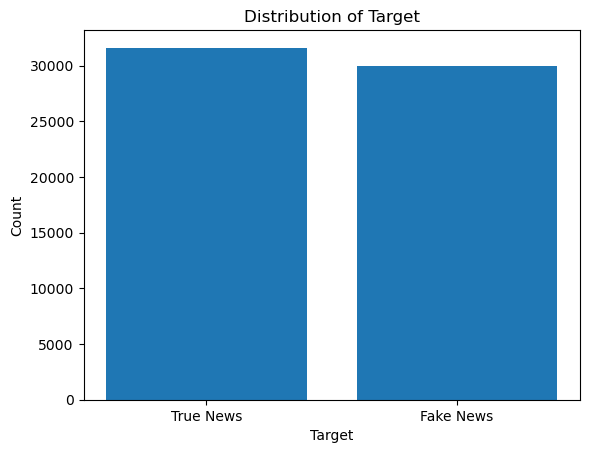

In [166]:
#Checking the distribution of our target, which is quite balanced

target_counts = df['target'].value_counts()

plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.xticks(target_counts.index, ['True News', 'Fake News'])
plt.show()

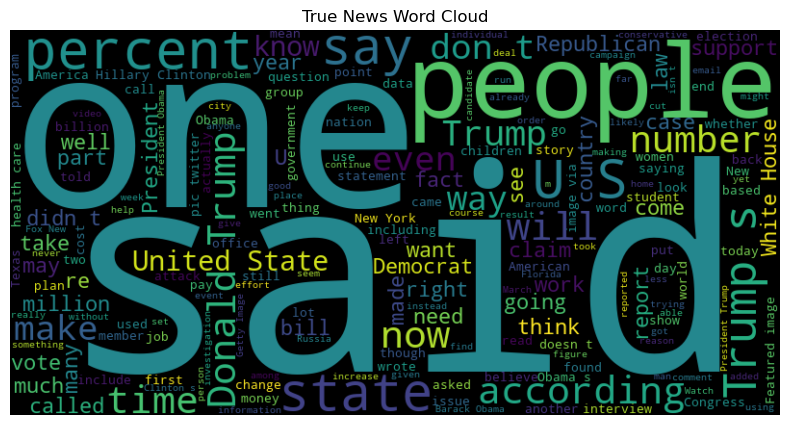

In [167]:
#Concatenating all the text as wordcloud expects a single text input

true_news_text = ' '.join(df[df['target'] == 0]['text'])

#Creating the wordcloud

wordcloud_true = WordCloud(width=800, height=400).generate(true_news_text)

#Creating the plot

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('True News Word Cloud')
plt.show()

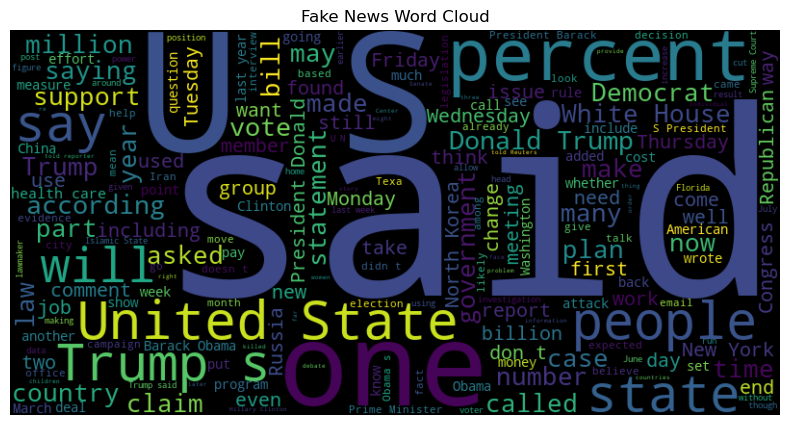

In [168]:
#Concatenating all the text as wordcloud expects a single text input

fake_news_text = ' '.join(df[df['target'] == 1]['text'])

#Creating the wordcloud

wordcloud_fake = WordCloud(width=800, height=400).generate(fake_news_text)

#Creating the plot

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')
plt.show()

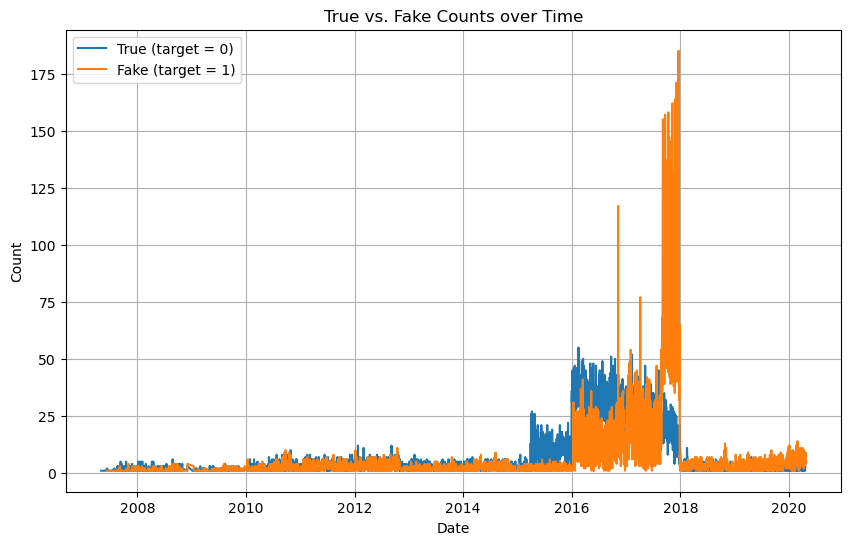

In [191]:
#Grouping the df by 'target' and 'date' columns and count the occurrences

count_by_target_date = df.groupby(['target', 'date']).size().reset_index(name='count')

#Separating the true (target = 0) and fake (target = 1) counts into different df

true_counts = count_by_target_date[count_by_target_date['target'] == 0]
fake_counts = count_by_target_date[count_by_target_date['target'] == 1]

#Creating time series charts for true (target = 0) and fake (target = 1) counts

plt.figure(figsize=(10, 6))
plt.plot(true_counts['date'], true_counts['count'], label='True (target = 0)')
plt.plot(fake_counts['date'], fake_counts['count'], label='Fake (target = 1)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('True vs. Fake Counts over Time')
plt.legend()
plt.grid(True)
plt.show()

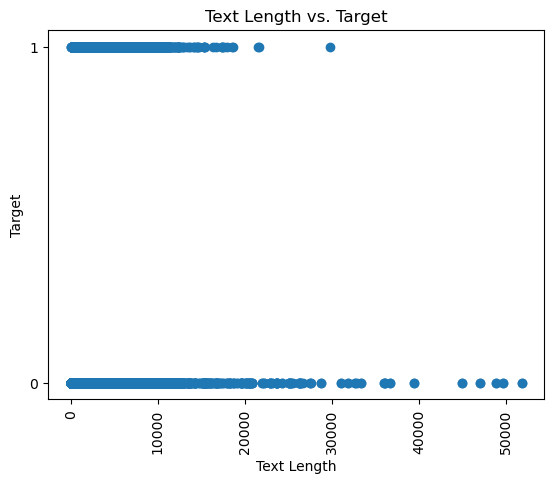

In [321]:
#We create a column to capture the length of the text of the news

df['text_length'] = df['text'].apply(len)

#We plot length across true and fake news

plt.scatter(df['text_length'], df['target'])
plt.xlabel('Text Length')
plt.ylabel('Target')
plt.title('Text Length vs. Target')
plt.xticks(rotation=90)
plt.yticks([0, 1]) 
plt.show()

It's interesting to see that generally fake news are shorter than true news.

### Feature Selection

In [192]:
#We create a column with the title and text of the news in one

df['title_text'] = df['title'] + " " + df['text']
df.head()

,title,text,date,target,title_text
0,MOTHER OF BENGHAZI VICTIM Rips Into Clueless C...,CNN Anchor Carol Costello acts like she s neve...,2015-10-21,0,MOTHER OF BENGHAZI VICTIM Rips Into Clueless C...
1,PICTURE OF Cop Walking Son To School On Day He...,"So what s worse, Barack Obama remaining silent...",2017-07-29,0,PICTURE OF Cop Walking Son To School On Day He...
2,The Amazing White Right-Wing Entitlement Of T...,"As of this writing, there are 4 heavily armed ...",2016-02-11,0,The Amazing White Right-Wing Entitlement Of T...
3,WATCH: JOEL OSTEEN FACES WRATH OF ANGRY CHRIST...,The popular evangelical preacher and inspirati...,2017-08-31,0,WATCH: JOEL OSTEEN FACES WRATH OF ANGRY CHRIST...
4,North Carolina offers reward in arson at local...,"North Carolina will pay up to $5,000 for tips ...",2016-10-19,1,North Carolina offers reward in arson at local...


### Text Cleaning

In [193]:
#We define the df that we will use to train our model

df_model = df[["title_text", "target"]]
df_model.head()

,title_text,target
0,MOTHER OF BENGHAZI VICTIM Rips Into Clueless C...,0
1,PICTURE OF Cop Walking Son To School On Day He...,0
2,The Amazing White Right-Wing Entitlement Of T...,0
3,WATCH: JOEL OSTEEN FACES WRATH OF ANGRY CHRIST...,0
4,North Carolina offers reward in arson at local...,1


In [194]:
#We define a function to process the text in our dataframe

def text_cleaner(text):
    #Convert text to lowercase
    text = text.lower()
    #Remove square brackets and their contents
    text = re.sub('\[.*?\]', '', text)
    #Replace non-word characters with a space
    text = re.sub("\\W"," ",text) 
    #Remove URLs or website addresses
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    #Remove punctuation marks
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #Remove newline characters
    text = re.sub('\n', '', text)
    #Remove alphanumeric words containing digits
    text = re.sub('\w*\d\w*', '', text)
    
    #Here we expand contractions (it's)
    text = contractions.fix(text)
    
    #Removing stopwords ("is", "an") and Lemmatization (Lemmatization reduces words to root form (running", "runs", "run"). 
    stopwords_set = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set]
    
    return " ".join(tokens)

In [195]:
#We apply our text cleaner function to df_model

df_model['title_text'] = df_model['title_text'].apply(text_cleaner)
df_model.head()

,title_text,target
0,mother benghazi victim rip clueless cnn anchor...,0
1,picture cop walking son school day murdered ap...,0
2,amazing white right wing entitlement oregon mi...,0
3,watch joel osteen face wrath angry christian g...,0
4,north carolina offer reward arson local republ...,1


### Logistic Regression

#### X-y Split

In [198]:
X = df_model["title_text"]
y = df_model["target"]

#### Train-Test Split

In [199]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Vectorizing the text

In [256]:
#Here we use a vectorizer to convert our strings to numerical vectors

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

#### Modeling

In [201]:
lr = LogisticRegression()
lr.fit(xv_train,y_train)

LogisticRegression()

In [202]:
predictions_lr = lr.predict(xv_test)

#### Evaluating

In [203]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6384
           1       0.89      0.87      0.88      5933

    accuracy                           0.89     12317
   macro avg       0.89      0.89      0.89     12317
weighted avg       0.89      0.89      0.89     12317



A simple logistic regression is giving us strong results across most metrics.

### Decision Tree Classifier

#### Modeling

In [205]:
dt = DecisionTreeClassifier()
dt.fit(xv_train, y_train)

DecisionTreeClassifier()

In [206]:
predictions_dt = dt.predict(xv_test)

#### Evaluating

In [207]:
print(classification_report(y_test, predictions_dt))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      6384
           1       0.85      0.83      0.84      5933

    accuracy                           0.85     12317
   macro avg       0.85      0.85      0.85     12317
weighted avg       0.85      0.85      0.85     12317



Decision Tree is also working reasonably well, although not as well as Logistic Regression.

### Random Forest Classifier

#### Modeling

In [209]:
rf = RandomForestClassifier(random_state=42)
rf.fit(xv_train, y_train)

RandomForestClassifier(random_state=42)

In [211]:
predictions_rf = rf.predict(xv_test)

#### Evaluating

In [212]:
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      6384
           1       0.89      0.84      0.87      5933

    accuracy                           0.88     12317
   macro avg       0.88      0.88      0.88     12317
weighted avg       0.88      0.88      0.88     12317



Random Forest is also working reasonably well, although Logistic Regression is still outperforming it slightly.

### Support Vector Machine

#### Modeling

In [231]:
svm = SVC(kernel='linear')
svm.fit(xv_train, y_train)

SVC(kernel='linear')

In [232]:
predictions_svm = svm.predict(xv_test)

#### Evaluating

In [233]:
print(classification_report(y_test, predictions_svm))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6384
           1       0.90      0.88      0.89      5933

    accuracy                           0.90     12317
   macro avg       0.90      0.90      0.90     12317
weighted avg       0.90      0.90      0.90     12317



Support Vector Machines are working well as well, outperforming all previous models. 

### Neural Nets

In the section below, we run two different neural networks - the first one is a feedforward neural net and the second one is a recurrent neural net. Neural networks are known to be powerful tools for text classification problems. 

#### Train / Test / Validation Split

In [213]:
#First, split the data into a 60% train set and a 40% temporary set (which is then split again).

train, temp = train_test_split(df_model, test_size=0.4, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

In [214]:
#We use this function to create a utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset, then shuffles and batches the data.
#Source: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?hl=en

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = df["title_text"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [215]:
#We apply the above function to our train, test and val data

train_data = df_to_dataset(train)
test_data = df_to_dataset(test)
val_data = df_to_dataset(val)

#### Embedding and Modeling (TensorFlow Hub embedding and feedforward architecture)

In [216]:
#Here we are using a Google trained embedding to create a hub layer that converts all strings in our dataset to numerical vectors

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [217]:
#Here we create our first neural net. We are adding multiple dense layers with different activation functions. We have also added two dropout layers to avoid overfitting. 

nn_hub = tf.keras.Sequential()
nn_hub.add(hub_layer)
nn_hub.add(tf.keras.layers.Dense(2, activation="relu"))
nn_hub.add(tf.keras.layers.Dropout(0.4))
nn_hub.add(tf.keras.layers.Dense(2, activation="relu"))
nn_hub.add(tf.keras.layers.Dropout(0.4))
nn_hub.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [218]:
#Here we compile the model we just created,using the popular Adam compiler, an appropriate loss function for classification problems and optimising towards accuracy. 

nn_hub.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=["accuracy"])

In [219]:
#Here we fit our model, using callback to find the optimal number of epochs. 

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = nn_hub.fit(train_data, epochs=100, validation_data=val_data, callbacks=[callback])

Epoch 1/100
1155/1155 [==============================] - 91s 79ms/step - loss: 0.6930 - accuracy: 0.5127 - val_loss: 0.6928 - val_accuracy: 0.5148
Epoch 2/100
1155/1155 [==============================] - 91s 78ms/step - loss: 0.6625 - accuracy: 0.5471 - val_loss: 0.4781 - val_accuracy: 0.8256
Epoch 3/100
1155/1155 [==============================] - 91s 79ms/step - loss: 0.6111 - accuracy: 0.6087 - val_loss: 0.4761 - val_accuracy: 0.8275
Epoch 4/100
1155/1155 [==============================] - 91s 79ms/step - loss: 0.6029 - accuracy: 0.6153 - val_loss: 0.4469 - val_accuracy: 0.8334
Epoch 5/100
1155/1155 [==============================] - 91s 78ms/step - loss: 0.5968 - accuracy: 0.6270 - val_loss: 0.4328 - val_accuracy: 0.8341
Epoch 6/100
1155/1155 [==============================] - 91s 78ms/step - loss: 0.5950 - accuracy: 0.6296 - val_loss: 0.4320 - val_accuracy: 0.8645
Epoch 7/100
1155/1155 [==============================] - 91s 79ms/step - loss: 0.5915 - accuracy: 0.6295 - val_loss: 0

In [220]:
#We evaluate against our test data, finding an accuracy of 51%. 

nn_hub.evaluate(test_data)

385/385 [==============================] - 5s 12ms/step - loss: 0.4231 - accuracy: 0.8448


[0.4230612814426422, 0.8447673916816711]

#### Encoding and Modeling (manual vectorization and recurrent neural network architecture)

In [257]:
#Here we define an encoder to vectorize text data and we encode our training data. 

encoder = tf.keras.layers.TextVectorization(max_tokens=3000)
encoder.adapt(train_data.map(lambda text, label: text))

In [258]:
#We check the vocabulary resulting from the encoding process. 

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'said', 'trump', 'state', 'would', 'year',
       'president', 'one', 'people', 'republican', 'say', 'percent',
       'tax', 'obama', 'new', 'also', 'time', 'government', 'law'],
      dtype='<U16')

In [259]:
#We define our lstm (long short-term memory) neural net, adding multiple layers inlcuding a dropout layer to avoid overfitting. 

regularizer = regularizers.l2(0.001)

nn_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32), #We added to LSTM layers to deal with the complexity of the text in training data
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer), #We added multiple dense layers to handle the more complex features from the increased LSTM layer
    tf.keras.layers.Dropout(0.5), #We added two dropout layers with high dropout rate to avoid overfitting
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizer),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizer),#Note that all dense layers are using a regularizer to minimize weights and avoid overfitting
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(1, activation='sigmoid') #The sigmoid activation function will return a probability close to 0 or 1
])

In [260]:
#Here we compile the model we just created,using the popular Adam compiler, an appropriate loss function for classification problems and optimising towards accuracy. 

nn_lstm.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=["accuracy"])

In [261]:
#Here we fit our model, again using the previously defined callback to find the appropriate number of epochs. 

history = nn_lstm.fit(train_data, epochs=100, validation_data=val_data, callbacks=[callback])

Epoch 1/100
1155/1155 [==============================] - 485s 417ms/step - loss: 0.3971 - accuracy: 0.8201 - val_loss: 0.2908 - val_accuracy: 0.8616
Epoch 2/100
1155/1155 [==============================] - 487s 422ms/step - loss: 0.3116 - accuracy: 0.8589 - val_loss: 0.3046 - val_accuracy: 0.8587
Epoch 3/100
1155/1155 [==============================] - 483s 418ms/step - loss: 0.2646 - accuracy: 0.8819 - val_loss: 0.2807 - val_accuracy: 0.8681
Epoch 4/100
1155/1155 [==============================] - 486s 421ms/step - loss: 0.2421 - accuracy: 0.8929 - val_loss: 0.2703 - val_accuracy: 0.8678
Epoch 5/100
1155/1155 [==============================] - 484s 419ms/step - loss: 0.2031 - accuracy: 0.9109 - val_loss: 0.2546 - val_accuracy: 0.8845
Epoch 6/100
1155/1155 [==============================] - 484s 419ms/step - loss: 0.1769 - accuracy: 0.9215 - val_loss: 0.2641 - val_accuracy: 0.8793
Epoch 7/100
1155/1155 [==============================] - 491s 425ms/step - loss: 0.1577 - accuracy: 0.9312

In [263]:
#Here we evaluate against our test data, finding an accuracy of 0.89%. 

nn_lstm.evaluate(test_data)

385/385 [==============================] - 32s 82ms/step - loss: 0.2993 - accuracy: 0.8856


[0.2992927134037018, 0.8856052756309509]

In [264]:
#We save this model to be used on a Streamlit app

nn_lstm.save('/Users/jesusb/Final_Project_Streamlit_Ironhack/nn_lstm_5')

INFO:tensorflow:Assets written to: /Users/jesusb/Final_Project_Streamlit_Ironhack/nn_lstm_5/assets


INFO:tensorflow:Assets written to: /Users/jesusb/Final_Project_Streamlit_Ironhack/nn_lstm_5/assets
